In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import pandas as pd
import netCDF4 as nc
import numpy as np

# stats tools
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [2]:
%matplotlib inline

In [3]:
cmap_mae = plt.cm.plasma_r # MAE colormap
cmap_line = plt.cm.plasma_r # line color "base"

camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

line_colors = [cmap_line(45), cmap_line(90), cmap_line(135), cmap_line(180), cmap_line(225)]

rgb_array = camp_t2(range(256))
vmap = colors.ListedColormap(rgb_array[::25], name='temp')

C1 = plt.cm.plasma(96)
C2 = plt.cm.plasma(225)
C3 = plt.cm.viridis(180)

In [4]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0.1, 
            'transparent':False}

In [5]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
    land_mask = hdf_io['land_mask'][...]
    #land_mask_terrain = hdf_io['land_mask_terrain'][...]

In [6]:
etopo_4km[etopo_4km<0]=0
etopo_4km[land_mask]=np.nan

In [7]:
with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
stn_elev = metadata['elev'].values
stn_code = metadata['stn code'].values

with h5py.File(PRISM_dir+'PRISM_regrid_BC_clim.hdf', 'r') as h_io:
    land_mask_BC = h_io['land_mask'][...]
    lon_BC = h_io['lon_4km'][...]
    lat_BC = h_io['lat_4km'][...]
    
indx, indy = du.grid_search(lon_BC, lat_BC, stn_lon, stn_lat)
flag_pick = ~land_mask_BC[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False

stn_indx, stn_indy = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)
etopo_stn = etopo_4km[stn_indx, stn_indy]
flag_good = np.abs(etopo_stn-stn_elev)/(5000-etopo_stn) < 0.01

flag_qc = np.logical_or(flag_pick, flag_good)

stn_lat = stn_lat[flag_qc]
stn_lon = stn_lon[flag_qc]
stn_elev = stn_elev[flag_qc]
stn_code = stn_code[flag_qc]

indx, indy = du.grid_search(lon_BC, lat_BC, stn_lon, stn_lat)
flag_pick = ~land_mask_BC[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False

In [8]:
flag_us = np.logical_not(flag_pick)

In [9]:
# fake_mask = np.zeros(land_mask_terrain.shape)
# fake_mask[land_mask_terrain]=1.0

In [10]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [11]:
CMap = LinearSegmentedColormap.from_list('temp_cmap', plt.cm.terrain(np.arange(48, 256).tolist()))

In [12]:
def arrow_pair(ax, leftpoint, midpoint, length1, length2, gap, width=0.0025, color='k'):
    ax.arrow(leftpoint, midpoint+gap, 0, length1, width=width, fc=color, ec=color, transform=ax.transAxes)
    ax.arrow(leftpoint, midpoint-gap, 0, -length2, width=width, fc=color, ec=color, transform=ax.transAxes)

In [13]:
#[edge[0], edge[0]+(68.4-48.5)/rate, 48, edge[3]]

In [14]:
# edge = [-141, -100, 28, 58.4]

# rate = 0.725
# edge_US = [-1*(48-edge[2])/rate+edge[1], edge[1], edge[2], 48]
# edge_BC = [edge[0], edge[0]+(68.4-48.5)/rate, 48, edge[3]]

# # edge_mid = 0.5*(edge[3] + edge[2])
# # gap = edge[3]-edge_mid

# fig = plt.figure(figsize=(13, 16))
# ax_base = fig.gca(projection=ccrs.PlateCarree())
# ax_US = fig.add_axes([0.525, -0.0785, 0.375, 0.4], projection=ccrs.PlateCarree())#
# ax_BC = fig.add_axes([0.125, 0.075, 0.375, 0.2], projection=ccrs.PlateCarree())

# ax_base.set_extent(edge, ccrs.Geodetic())
# ax_base.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
# ax_base.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=1.5)
# ax_base.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
# ax_base.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=1.5)
# ax_base.outline_patch.set_linewidth(2.5)
    
# ax_US.set_extent(edge_US, ccrs.Geodetic())
# ax_BC.set_extent(edge_BC, ccrs.Geodetic())

# for ax in [ax_US, ax_BC]:
#     ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
#     ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='0.5', linewidth=0.5, zorder=1.0)
#     ax.add_feature(cfeature.BORDERS.with_scale(scale_param), edgecolor='0.5', linestyle='--', linewidth=1.0)
#     ax.add_feature(PROVINCE, edgecolor='0.5', linestyle=':', linewidth=1.5, zorder=1.0)
#     ax.outline_patch.set_linewidth(2.5)

# ax = ax_base
# GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
# GL.xlabels_top = False
# GL.ylabels_right = False
# GL.xformatter = LONGITUDE_FORMATTER
# GLyformatter = LATITUDE_FORMATTER
# GL.xlabel_style = {'size': 14}
# GL.ylabel_style = {'size': 14}
# #GL.ylocator = mticker.FixedLocator([])
# #GL.xlocator = mticker.FixedLocator([])
# CS = ax.pcolormesh(lon_4km, lat_4km, etopo_4km, vmin=0.001, vmax=2499.999, cmap=CMap)
# handle = []
# handle += ax_BC.plot(stn_lon[flag_pick], stn_lat[flag_pick] ,'b.', label='GHCN daily in BC: CA001#')
# handle += ax_US.plot(stn_lon[flag_us], stn_lat[flag_us] ,'r.', label='GHCN daily: USS00#, USR00#, USW00#')

# C = 'b'
# ax.hlines(lat_4km[ind_trans, 0], xmin=-133.85, xmax=edge[1], linestyle='-', color=C, lw=4)   
# ax.hlines(48.5, xmin=-133.85, xmax=-125.5, linestyle='-', color=C, lw=4) 
# ax.hlines(49, xmin=-112, xmax=edge[1], linestyle='-', color=C, lw=4)

# arrow_pair(ax, 0.13, 0.4237, 0.51, 0.36, 0.05, width=0.0025, color=C)
# ax.text(0.13, 0.4237, 'Coverage of reanalysis\ndata that used for the\ntraining of Cycle-GAN', 
#         fontsize=14, ha='center', va='center', color=C, transform=ax.transAxes);

# arrow_pair(ax, 0.32, 0.265, 0.203, 0.203, 0.05, width=0.0025, color='r')
# ax.text(0.32, 0.2625, 'Coverage of PRISM (US)\nthat used for the training\nof Cycle-GAN and UNet', 
#         fontsize=14, ha='center', va='center', color='r', transform=ax.transAxes);
# ax.text(0.28, 0.585, 'Coverage of PRISM\n(US) that used for\nthe validation of UNet', 
#         fontsize=14, ha='center', va='center', color=C, transform=ax.transAxes);

# arrow_pair(ax, 0.79, 0.829, 0.11, 0.11, 0.05, width=0.0025, color=C)
# ax.text(0.79, 0.829, 'The transferring domain for analyzing\nthe spatial generalization performance\nof our methods', 
#         fontsize=14, ha='center', va='center', color=C, transform=ax.transAxes, zorder=5);

# #ax.text(0.315, 0.5375, '45$^\circ$N', fontsize=14, ha='left', va='bottom', color=C, transform=ax.transAxes);

# points = [[-111, 53.1], [-111, 56], [-101, 56], [-101, 53.1]]
# boxes = PatchCollection([patches.Polygon(points)], facecolor='0.85', edgecolor='none', linewidth=0, zorder=4)
# ax.add_collection(boxes)
# points = [[-111, 28.5], [-111, 30], [-105, 30], [-105, 28.5]]
# boxes = PatchCollection([patches.Polygon(points)], facecolor='0.85', edgecolor='none', linewidth=0, zorder=4)
# ax.add_collection(boxes)

# text_kwargs = dict(fontsize=14, color='k')
# plot_kwargs = dict(linestyle='-', color='k')
# gu.scale_bar(ax, (0.74, 0.025), 500000, metres_per_unit=1, unit_name='m', text_kwargs=text_kwargs, plot_kwargs=plot_kwargs, zorder=5)
# gu.scale_bar(ax_BC, (0.1, 0.1), 500000, metres_per_unit=1, unit_name='m', text_kwargs=text_kwargs, plot_kwargs=plot_kwargs, zorder=5)
# gu.scale_bar(ax_US, (0.1, 0.1), 500000, metres_per_unit=1, unit_name='m', text_kwargs=text_kwargs, plot_kwargs=plot_kwargs, zorder=5)

# ax_lg = fig.add_axes([0.125, 0.0525, 0.375, 0.05])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=handle, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})
# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(0)

# cax = fig.add_axes([0.125, 0.0205, 0.375, 0.02])#
# CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)  
# CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
# CBar.set_label('m', fontsize=14, x=1, labelpad=-15, ha='right', va='top')
# CBar.outline.set_linewidth(2.5)

# # # Save figure
# # fig.savefig(fig_dir+'CGAN_domain_elev.png', format='png', **fig_keys)

In [15]:
edge_BC

NameError: name 'edge_BC' is not defined

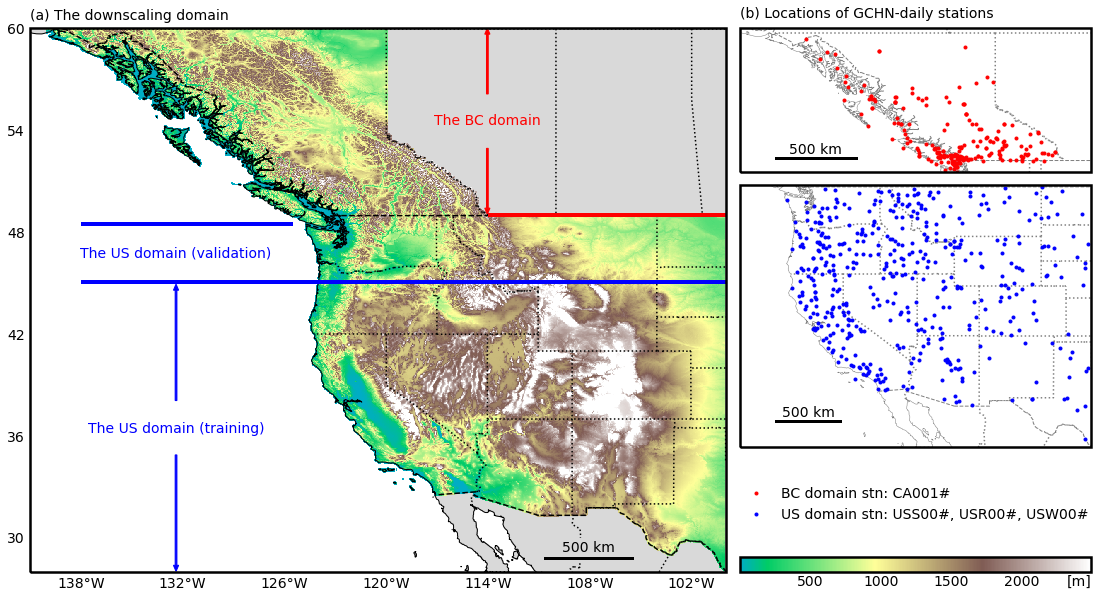

In [16]:
edge = [-141, -100, 28, 58.4]

rate = 0.725
edge_US = [-1*(48.5-edge[2])/rate+edge[1], edge[1], edge[2], 48.5]
edge_BC = [edge[0]-1, edge[0]+(69.75-48.5)/rate, 48, 59.75]

# edge_mid = 0.5*(edge[3] + edge[2])
# gap = edge[3]-edge_mid

fig = plt.figure(figsize=(13, 10))
ax_base = fig.gca(projection=ccrs.PlateCarree())

ax_BC = fig.add_axes([0.9, 0.68, 0.375, 0.2], projection=ccrs.PlateCarree())#0.9
ax_US = fig.add_axes([0.9, 0.28, 0.375, 0.4], projection=ccrs.PlateCarree())

ax_base.set_extent(edge, ccrs.Geodetic())
ax_base.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
ax_base.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=1.5)
ax_base.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
ax_base.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=1.5)
ax_base.outline_patch.set_linewidth(2.5)
    
ax_US.set_extent(edge_US, ccrs.Geodetic())
ax_BC.set_extent(edge_BC, ccrs.Geodetic())

titles = ['(a) The downscaling domain', '(b) Locations of GCHN-daily stations']

for ax in [ax_US, ax_BC]:
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='0.5', linewidth=0.5, zorder=1.0)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), edgecolor='0.5', linestyle='--', linewidth=1.0)
    ax.add_feature(PROVINCE, edgecolor='0.5', linestyle=':', linewidth=1.5, zorder=1.0)
    ax.outline_patch.set_linewidth(2.5)

ax = ax_base
GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
GL.xlabels_top = False
GL.ylabels_right = False
GL.xformatter = LONGITUDE_FORMATTER
GL.yformatter = LATITUDE_FORMATTER
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}

ax_base.text(0, 1+0.05*0.2, titles[0], fontsize=14, ha='left', va='bottom', transform=ax_base.transAxes)
ax_BC.text(0, 1.05, titles[1], fontsize=14, ha='left', va='bottom', transform=ax_BC.transAxes)

CS = ax.pcolormesh(lon_4km, lat_4km, etopo_4km, vmin=0.001, vmax=2499.999, cmap=CMap)
handle = []
handle += ax_BC.plot(stn_lon[flag_pick], stn_lat[flag_pick] ,'r.', label='BC domain stn: CA001#')
handle += ax_US.plot(stn_lon[flag_us], stn_lat[flag_us] ,'b.', label='US domain stn: USS00#, USR00#, USW00#')

C1 = 'r'
C2 = 'b'
C3 = 'g'
locx = 0.21
ax.hlines(lat_4km[ind_trans, 0], xmin=-138, xmax=edge[1], linestyle='-', color=C2, lw=4)   
ax.hlines(48.5, xmin=-138, xmax=-125.5, linestyle='-', color=C2, lw=4) 
ax.hlines(49, xmin=-114, xmax=edge[1], linestyle='-', color=C1, lw=4)

# arrow_pair(ax, 0.13, 0.4237, 0.51, 0.36, 0.05, width=0.0025, color=C3)
# ax.text(0.13, 0.4237, 'The coverage of\nUS and BC domain', 
#         fontsize=14, ha='center', va='center', color=C3, transform=ax.transAxes);

arrow_pair(ax, locx, 0.265, 0.203, 0.203, 0.05, width=0.0025, color=C2)
ax.text(locx, 0.585, 'The US domain (validation)', 
        fontsize=14, ha='center', va='center', color=C2, transform=ax.transAxes);
ax.text(locx, 0.2625, 'The US domain (training)', 
        fontsize=14, ha='center', va='center', color=C2, transform=ax.transAxes);

arrow_pair(ax, 0.6575, 0.829, 0.11, 0.11, 0.05, width=0.0025, color=C1)
ax.text(0.6575, 0.829, 'The BC domain', fontsize=14, ha='center', va='center', color=C1, transform=ax.transAxes, zorder=5);

# points = [[-111, 53.1], [-111, 56], [-108, 56], [-108, 53.1]]
# boxes = PatchCollection([patches.Polygon(points)], facecolor='0.85', edgecolor='none', linewidth=0, zorder=4)
# ax.add_collection(boxes)
points = [[-111, 28.5], [-111, 30], [-105, 30], [-105, 28.5]]
boxes = PatchCollection([patches.Polygon(points)], facecolor='0.85', edgecolor='none', linewidth=0, zorder=4)
ax.add_collection(boxes)

text_kwargs = dict(fontsize=14, color='k')
plot_kwargs = dict(linestyle='-', color='k')
gu.scale_bar(ax, (0.74, 0.025), 500, metres_per_unit=1000, unit_name='km', text_kwargs=text_kwargs, plot_kwargs=plot_kwargs, zorder=5)
gu.scale_bar(ax_BC, (0.1, 0.1), 500, metres_per_unit=1000, unit_name='km', text_kwargs=text_kwargs, plot_kwargs=plot_kwargs, zorder=5)
gu.scale_bar(ax_US, (0.1, 0.1), 500, metres_per_unit=1000, unit_name='km', text_kwargs=text_kwargs, plot_kwargs=plot_kwargs, zorder=5)

ax_lg = fig.add_axes([0.91, 0.21, 0.375, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=handle, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

cax = fig.add_axes([0.9, 0.125, 0.375, 0.02])#
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)  
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('[m]', fontsize=14, x=1, labelpad=-14, ha='right', va='top')
CBar.outline.set_linewidth(2.5)

# Save figure
fig.savefig(fig_dir+'CGAN_domain_elev.png', format='png', **fig_keys)